<a href="https://colab.research.google.com/github/Krish716/test-repo/blob/master/actual_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install spectral

     |████████████████████████████████| 212 kB 5.3 MB/s 


In [ ]:
import scipy.io as sio

In [ ]:
from spectral import *

In [ ]:
data = sio.loadmat('/content/drive/My Drive/Indian_pines_gt.mat')

In [ ]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])

In [ ]:
import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D,LSTM
from keras.optimizers import SGD
from keras import backend as K
from keras.utils import np_utils

from keras.layers.convolutional import *
from keras.utils import conv_utils
from keras.layers.core import *
from keras.engine.topology import Layer

import numpy.random as rng
import numpy as np
import scipy.io as sio
import random
from random import shuffle
import matplotlib.pyplot as plt

import os.path
import errno

import spectral
import scipy.ndimage
from skimage.transform import rotate

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

import pandas as pd

# Global Variables
numComponents = 100
windowSize = 5
testRatio = 0.25
lr = 0.0001
isPCA = True

PATCH_SIZE = 5

def loadIndianPinesData():
    data = sio.loadmat('/content/drive/My Drive/Indian_pines.mat')['indian_pines']
    print(type(data))
    print(len(data))
    labels = sio.loadmat('/content/drive/My Drive/Indian_pines_gt.mat')['indian_pines_gt']
    return data, labels
def splitTrainTestSet(X, y, testRatio=0.10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

def applyNMF(X, numComponents=75):
    nmf = NMF(n_components=numComponents, init='random', random_state=0)
    newX = nmf.fit_transform(X)
    return newX, nmf

def applyPCA(X, numComponents=75, isReshape = True, drawPlot = False, layerNo = 1):
    if isReshape == True:
        newX = np.reshape(X, (-1, X.shape[2]))
        pca = PCA(n_components=numComponents, whiten=True)
        newX = pca.fit_transform(newX)
        newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    else: 
        pca = PCA(n_components=numComponents, svd_solver='full')
        newX = pca.fit_transform(X)
        if drawPlot == True:
            drawPCAPlot(pca.explained_variance_ratio_,numComponents, layerNo)
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createPatches(X, y, windowSize=5):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1    
    patchesData = patchesData[patchesLabels>0,:,:,:]
    patchesLabels = patchesLabels[patchesLabels>0]
    patchesLabels -= 1
    return patchesData, patchesLabels

def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)  
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    return X_train

def getModel(input_shape, numComponents):
    model = Sequential()
    model.add(Conv2D(numComponents, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(numComponents, (3, 3)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(2*numComponents))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(14))
    model.add(Activation('softmax'))
    return model

def getClassificationImages(model, X, y, filename, PATCH_SIZE=5, isSave = True, isShow = False):
    height = y.shape[0]
    width = y.shape[1]
    outputs = np.zeros((height,width))
    for i in range(height-PATCH_SIZE+1):
        for j in range(width-PATCH_SIZE+1):
            target = int(y[i+int(PATCH_SIZE/2), j+int(PATCH_SIZE/2)])
            if target == 0 :
                continue
            else :
                image_patch=Patch(X,i,j)
                X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
                prediction = (model.predict_classes(X_test_image))                         
                outputs[i+int(PATCH_SIZE/2)][j+int(PATCH_SIZE/2)] = prediction+1
    if isSave == True:
        spectral.save_rgb(filename, data= outputs.astype(int), colors=spectral.spy_colors)
    if isShow == True:
        predict_image = spectral.imshow(classes = outputs.astype(int), figsize =(5,5))


In [ ]:
n_classes=16

def get_batch(batch_size):
    """
    Create batch of n pairs, half same class, half different class
    """
    categories = y_train
    n_examples, w, h, ch = X_train.shape
    
    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,))
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w, ch)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        a = np.where(y_train==category)
        idx_1 = rng.choice(a[0])
        pairs[0][i,:,:,:] = X_train[idx_1]
        
        # pick images of diff class for 1st half, same for 2nd
        if i < batch_size // 2: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
            b = np.where(y_train==category_2)
            idx_2 = rng.choice(b[0])
        else:
            index = np.argwhere(a[0]==idx_1)
            b = np.delete(a[0],index)
            idx_2 = rng.choice(b)
            
        pairs[1][i,:,:,:] = X_train[idx_2]
        #print(idx_1,idx_2, y_train[idx_1], y_train[idx_2])
    
    return pairs, targets
  
def generate(batch_size, s="train"):
    """
    a generator for batches, so model.fit_generator can be used.
    """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [ ]:
def getSiameseModel(input_shape):  
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = Sequential()
    model.add(Conv2D(120, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))   
    model.add(MaxPooling2D(pool_size=(5, 5), strides=None, padding='same'))
    
    model.add(Dropout(0.335))
    model.add(Flatten())
    model.add(Dense(1000))#,kernel_initializer=W_init,bias_initializer=b_init))
    model.add(Activation('softsign'))
         
    model.add(Dense(500))
    model.add(Activation('relu'))
            
    model.add(Dense(300))
    model.add(Activation('relu'))
    
    encoded_l = model(left_input)
    encoded_r = model(right_input)    
     # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])    
    # or ###both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance) #bias_initializer=initialize_bias    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)    
    # return the model
    return siamese_net

In [ ]:
def triplet_loss(y_true, y_pred, alpha = 0.993002):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """

    anchor = y_pred[:,0:3]
    positive = y_pred[:,3:6]
    negative = y_pred[:,6:9]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [ ]:
y.shape

(145, 145)

In [ ]:
def pred_sample(w):
    classes = np.unique(y_train)
    
    pairs = [np.zeros((16, w.shape[0], w.shape[1], w.shape[2])) for i in range(2)]
    for i in range(len(classes)):
        category = classes[i]
        a = np.where(y_train==category)
        idx_1 = rng.choice(a[0])
        pairs[0][i,:,:,:] = X_train[idx_1]
                
        pairs[1][i,:,:,:] = w
    
    return pairs

In [ ]:
X, y = loadIndianPinesData()
isShow = True
# PCA
if isPCA == True:
    X,pca = applyPCA(X,numComponents=numComponents)
    X_pca =X

# NMF
elif isPCA == False:
    X = X.reshape((1476*256,145))
    X, nmf = applyNMF(X,numComponents)
    #X = X.reshape((145,145,numComponents))
    X_nmf = X

XPatches, yPatches = createPatches(X, y, windowSize=windowSize)

X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio)

X_train, y_train = oversampleWeakClasses(X_train, y_train)

X_train = AugmentData(X_train)


X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))
y_test = np_utils.to_categorical(y_test)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[3], X_train.shape[1], X_train.shape[2]))
y_train = np_utils.to_categorical(y_train)


<class 'numpy.ndarray'>
145


In [ ]:
X.shape

(145, 145, 100)

In [ ]:
a = np.where(y_train==category)
len(a[0])

In [ ]:
ind, il = loadIndianPinesData()

<class 'numpy.ndarray'>
1476


In [ ]:
ind.shape

(1476, 256, 145)

In [ ]:
data = sio.loadmat('/content/drive/My Drive/Botswana.mat')['Botswana']
labels = sio.loadmat('/content/drive/My Drive/Botswana_gt.mat')['Botswana_gt']

In [ ]:
(labels==14).sum()

95

In [ ]:
d = sio.loadmat('/content/drive/My Drive/Botswana.mat')

In [ ]:
d.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Botswana'])

In [ ]:
from spectral import *

In [ ]:
data = sio.loadmat('/content/drive/My Drive/Botswana.mat')['Botswana']
labels = sio.loadmat('/content/drive/My Drive/Botswana_gt.mat')['Botswana_gt']

In [ ]:
for i in range(145):
    v = imshow( data,(i,4,14),interpolation='nearest',aspect='auto')

In [ ]:
X_train.shape

(29685, 25, 100)

In [ ]:
model = getModel(X_train.shape,numComponents)
opt = keras.optimizers.Adam(lr=lr,decay=1e-6)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#for i in range(X_train.shape[0]//100):
#    ip,op = get_batch(100) 
history = model.fit(X_train,y_train , epochs=9, batch_size=100,verbose=True)

ground_truth = spectral.imshow(classes = y,figsize =(5,5), interpolation='nearest',aspect='auto')
if isPCA == True:
    getClassificationImages(model, X, y, filename = "PCAVanillaClassification.png", PATCH_SIZE=5)
elif isPCA == False:
    getClassificationImages(model, X, y, filename = "NMFVanillaClassification.png", PATCH_SIZE=5)

ValueError: ignored

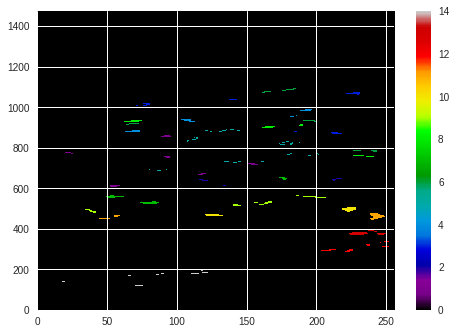

In [ ]:
plt.imshow(y, origin="lower", cmap='nipy_spectral', interpolation='nearest',aspect='auto')
plt.colorbar()
plt.show()

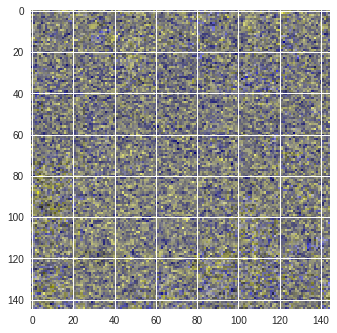

In [ ]:
if isPCA==True:
    spectral.imshow( X,(145,145,34),cmap='nipy_spectral')
else:
    spectral.imshow( X_nmf,(145,145,34),cmap='nipy_spectral')

In [ ]:
from google.colab import files
from PIL import Image

#with open('example.png', 'w') as f:
#    f.write('PCAVanillaClassification.png')
#files.download('x.png')

In [ ]:
print(X.shape)

(145, 145, 180)


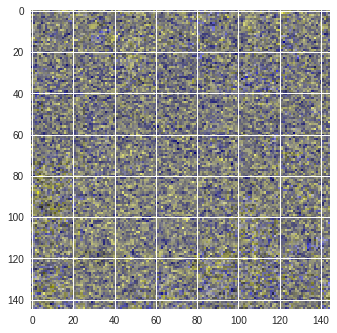

In [ ]:
if isPCA==True:
    spectral.imshow( X,(145,145,34),cmap='nipy_spectral')
else:
    spectral.imshow( X_nmf,(145,145,34),cmap='nipy_spectral')

In [ ]:
print(X_nmf.shape)

(145, 145, 180)


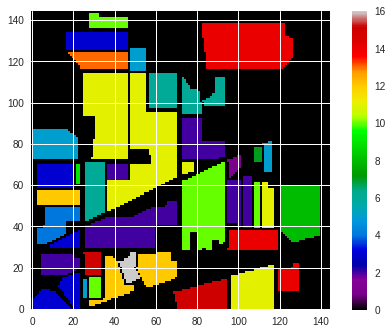

In [ ]:
plt.imshow(y, origin="lower", cmap='nipy_spectral', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
with open('mycsvfile.csv','wb') as f:
    w = csv.writer(f)
    w.writerows(mat.items())
    f.close()

In [ ]:
uploaded = drive.CreateFile({'title': 'NMFVanillaClassification.png'})

AttributeError: ignored

In [ ]:
from google.colab import files
from PIL import Image

#with open('example.png', 'w') as f:
#    f.write('PCAVanillaClassification.png')
files.download('PCAVanillaClassification.png')

In [ ]:
model = getSiameseModel(X_train[0].shape)
opt = keras.optimizers.Adam(lr=lr,decay=1e-6)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train,y_train , epochs=5, batch_size=10,verbose=False)
ground_truth = spectral.imshow(classes = y,figsize =(5,5))
getClassificationImages(model, X, y, filename = "PCAVanillaClassification.png", PATCH_SIZE=7)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
history.history['acc']

[0.9360009294699113,
 0.941390858859913,
 0.9452838128075287,
 0.9549604162375533,
 0.9643696299783103]

In [ ]:
pred=[]
for i in X_test:
    t = pred_sample(i)
    pr = model.predict(t)
    pred.append(list(pr).index(max(pr)))
print(accuracy_score(y_test,pred))

NameError: ignored

In [ ]:
plt.imshow(y, origin="lower", cmap='nipy_spectral', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(X_nmf,cmap='nipy_spectral')

ImageView object:
  Display bands       :  (34, 34, 34)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 23.43079511842737]
    G: [0.0, 23.43079511842737]
    B: [0.0, 23.43079511842737]

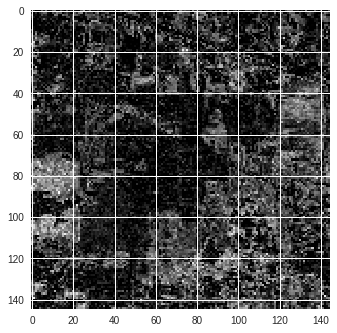

In [ ]:
 spectral.imshow( X_nmf,(34,34,34),cmap='nipy_spectral')